## Notes

### Image
* Image size is 128 x 128

In [114]:
import pandas as pd
import numpy as np
import tensorflow as tf
import keras as k
from PIL import Image
from tqdm.notebook import tqdm
import os
from sklearn import preprocessing
import wandb
from wandb.keras import WandbCallback
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
%matplotlib inline

gpu_available = tf.test.is_gpu_available()
is_cuda_gpu_available = tf.test.is_gpu_available(cuda_only=True)

print(gpu_available, is_cuda_gpu_available)

False False


In [103]:
wandb.init(project="aircraft-project", entity="thompson_e")

In [48]:
batch_size = 128
img_height = 128
img_width = 128

In [49]:
training_path = 'Train/'
label_file = 'train.csv'
image_path = 'Train/in_images'

y_ambi = set(['other-airplane', 'A220', 'Boeing787', 'Boeing777', 'Boeing737', 'Boeing747', 
                   'C919', 'A321', 'A350', 'A330', 'ARJ21'])
y_clean = labels_ambi = set(['A220', 'Boeing787', 'Boeing777', 'Boeing737', 'Boeing747', 
                   'C919', 'A321', 'A350', 'A330', 'ARJ21'])

In [50]:
# use this to limit the ambiguous choice of "other airplane"
USE_CLEAN = True

In [51]:
labels = pd.read_csv(f'{training_path}{label_file}')
if USE_CLEAN:
    labels = labels[labels.label != 'other-airplane']
labels = labels.to_numpy()

labels

array([['5690_0.png', 'A220'],
       ['5690_1.png', 'A220'],
       ['5690_2.png', 'A220'],
       ...,
       ['4597_0.png', 'Boeing737'],
       ['4597_1.png', 'A321'],
       ['4597_3.png', 'Boeing737']], dtype=object)

In [99]:
class Model:
    def __init__(self):
        self.model = self.build_model()
        print(self.model.summary())
    
    def build_model(self):
        model = tf.keras.Sequential([
            tf.keras.layers.InputLayer((128,128,3)),
            tf.keras.layers.Conv2D(8,9),
            tf.keras.layers.MaxPool2D(),
            tf.keras.layers.Conv2D(4,3),
            tf.keras.layers.MaxPool2D(),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(64,activation='relu'),
            tf.keras.layers.Dense(128,activation='relu'),
            tf.keras.layers.Dense(128,activation='relu'),
            tf.keras.layers.Dense(10, activation='softmax'),
        ])
        opt = tf.keras.optimizers.SGD(learning_rate=0.003)
        model.compile(optimizer=opt, 
              loss='sparse_categorical_crossentropy', metrics=['accuracy'])

        return model

In [100]:
model = Model()

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_34 (Conv2D)          (None, 120, 120, 8)       1952      
                                                                 
 max_pooling2d_24 (MaxPoolin  (None, 60, 60, 8)        0         
 g2D)                                                            
                                                                 
 conv2d_35 (Conv2D)          (None, 58, 58, 4)         292       
                                                                 
 max_pooling2d_25 (MaxPoolin  (None, 29, 29, 4)        0         
 g2D)                                                            
                                                                 
 flatten_17 (Flatten)        (None, 3364)              0         
                                                                 
 dense_53 (Dense)            (None, 64)              

In [54]:
X = []
for file in tqdm(labels[:,0]):
    image = Image.open(f'{image_path}/{file}')
    image = np.asarray(image)[:,:,:3]/255
    X.append(image)
X = np.array(X)

  0%|          | 0/20349 [00:00<?, ?it/s]

In [55]:
print(X.shape, labels.shape)

(20349, 128, 128, 3) (20349, 2)


In [115]:
le = preprocessing.LabelEncoder()
le.fit(labels[:,1])
print(le.classes_)
y = le.transform(labels[:,1])

['A220' 'A321' 'A330' 'A350' 'ARJ21' 'Boeing737' 'Boeing747' 'Boeing777'
 'Boeing787' 'C919']


In [146]:
X_train, X_test, y_train, y_test= train_test_split(X, y, test_size=0.2, shuffle = True)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.2, random_state=1)

print(X_train.shape, X_test.shape, X_val.shape)

(16279, 128, 128, 3) (3256, 128, 128, 3) (814, 128, 128, 3)


In [104]:
model.model.fit(X, y, epochs=50,use_multiprocessing=True,verbose=1, 
                batch_size=128, validation_data=(X_test,y_test) ,callbacks=[WandbCallback()])

Epoch 1/50
159/159 [==============================] - 85s 534ms/step - loss: 1.9843 - accuracy: 0.2846 - val_loss: 1.9415 - val_accuracy: 0.2936
Epoch 2/50
159/159 [==============================] - 87s 546ms/step - loss: 1.9296 - accuracy: 0.2969 - val_loss: 1.9360 - val_accuracy: 0.2942
Epoch 3/50
159/159 [==============================] - 83s 519ms/step - loss: 1.9095 - accuracy: 0.2988 - val_loss: 1.8891 - val_accuracy: 0.2998
Epoch 4/50
159/159 [==============================] - 89s 561ms/step - loss: 1.8934 - accuracy: 0.3002 - val_loss: 1.8711 - val_accuracy: 0.2991
Epoch 5/50
159/159 [==============================] - 84s 527ms/step - loss: 1.8700 - accuracy: 0.3062 - val_loss: 1.8898 - val_accuracy: 0.3007
Epoch 6/50
159/159 [==============================] - 86s 539ms/step - loss: 1.8554 - accuracy: 0.3125 - val_loss: 1.8135 - val_accuracy: 0.3369
Epoch 7/50
159/159 [==============================] - 87s 549ms/step - loss: 1.8238 - accuracy: 0.3269 - val_loss: 1.8151 - val_ac

In [107]:
model.model.evaluate(X_val, y_val)  

26/26 [==============================] - 1s 33ms/step - loss: 0.3076 - accuracy: 0.9103


[0.3076232373714447, 0.9103193879127502]

In [152]:
preds = model.model.predict(X_val)
p = np.argmax(preds, axis=1)

correct = 0

for i in range(len(p)):
    if p[i] == y_val[i]:
        correct += 1
print(correct, len(p)-correct, len(p))
print(f'Overall Accuracy: {((correct/len(p))*100):.2f}%')

747 67 814
Overall Accuracy: 91.77%


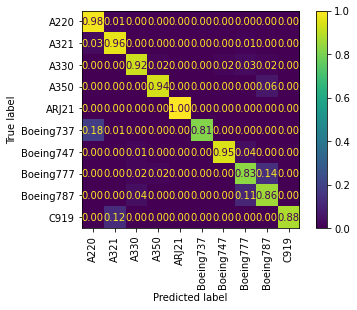

In [153]:
cm = confusion_matrix(y_val,p, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=le.classes_)
d = disp.plot(xticks_rotation='vertical', values_format='.2f')

In [145]:
model.model.save('90p-accuracy')
model.model.save('90p-accuracy.h5')


INFO:tensorflow:Assets written to: 90p-accuracy/assets
